
# 💡 Prédiction consommation d'énergie 

|   |   |
|---|---|
| Projet  | Anticipez les besoins en consommation de bâtiments.                       |
| Date   | Novembre 2022                                                 |
| Auteur  | Ana Bernal                                                    |
|Source| [2016 Seattle Energy Benchmarking](https://data.seattle.gov/dataset/2016-Building-Energy-Benchmarking/2bpz-gwpy)
| Notebook numéro  | 2 sur 3                                                    |

## Contenu

* [Préliminaires](#pre) : Imports, graphiques et options, définitions des fonctions utiles, Lecture données.
* [Préparation des données](#prep) : Choix features, renommer le target, traslation d'une variable, matrice de features X et target y, codage des variables qualitatives, séparation: train test, standardisation des variables.
* [Modélisation](#mod)
    - [**Dummy** regressor](#dum)
    - [Regression **linéaire** simple](#lin)
        + [Regression linéaire simple, cible transformé](#linlog)
    - [Regression **ridge** : validation croisée](#rid)
        + [Validation croisée](#ridcv)
        + [Entraînement ridge meilleurs paramètres](#ridbest)
        + [Regression ridge avec transformation de cible: log](#ridlog)
    - [Regression **LASSO**](#lass)
        + [Validation croisée](#lasscv)
        + [Entraînement lasso meilleurs paramètres](#lassbest)
        + [Regression ridge avec transformation de cible: log](#lasslog)
    - [**S**upport **V**ector **R**egression](#SVR)
    - [**Fôrets aléatoires**](#for)
        + [Recherche hyper-paramètres: validation croisée](#forcv)
        + [Entraînement fôrets meilleurs paramètres](#forbest)
        + [Feature importance](#fimp)
        + [RandomForest avec transformation target: log](#forlog)
    - [**XGBoost**](#xgb)
    - [XGBoost régularisé](#xgbr)
        + [Entraînement meilleurs paramètres](#xgbrbest)
    - [**Gradient Boosting**](#gbo)
* [Comparatif **Résultats**](#res)
    - [Comparatif score R2](#r2)
    - [Comparatif RMSE](#rmse) 
* [Ajout de variable **EnergyScore**](#ene)
    - [Comparatif résultats (r2 score et RMSE)](#erre)
* [**Conclusions**, commentaires et **choix de modèle**](#concl)


# Préliminaires<a class="anchor" id="pre"></a>

Les données utilisés ici ont déjà été nettoyées. Voir notebook d'exploration.

## Imports

In [1]:
# built-in
import os, warnings, time

import pandas as pd
import numpy as np

# preprocessing
from sklearn.preprocessing import StandardScaler
# metrics
from sklearn.metrics import mean_squared_error, r2_score
# estimators
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import Ridge
from sklearn.linear_model import LassoCV
from sklearn.linear_model import Lasso
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.svm import SVR
from xgboost import XGBRegressor
# model selection
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
# compose
from sklearn.compose import TransformedTargetRegressor
# feature importance
import shap

# visualisation
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import seaborn as sns

## Graphiques et options

In [2]:
sns.set()

# warnings.filterwarnings('ignore')
warnings.filterwarnings(action='once')

## Définitions des fonctions utiles

In [3]:
def score(estimator,X_train,X_test,y_train,y_test):
    """
    Computes and print train score and test score.
    
    Parameters:
        
        estimator
        
    Returns:
    
        [tr_score, te_score] : list
            list of scores
    """
    
    tr_score = estimator.score(X_train, y_train).round(4)
    te_score = estimator.score(X_test, y_test).round(4)
    
    print(f'score train : {tr_score}, score test : {te_score}')
    
    return [tr_score,te_score]


def rmse(y_test,y_pred):
    """
    Prints and returns the rooted mean squared error
    for the test set and the prediction.
    """
    RMSE = mean_squared_error(y_test, y_pred, squared=False).round(2)

    print(f'The RMSE is: {RMSE}')
    
    return RMSE

def append_dic(model_name,estimator,dic,X_train,X_test,y_train,y_test):
    """
    Appends scores to the dictionnary errors_df
    which keeps tracks of all scores for
    every model.
    """
        
    global fit_time, predict_time, y_pred, score
    
    RMSE = rmse(y_test,y_pred)
    score_ = score(estimator,X_train,X_test,y_train,y_test)
    

    dic['Name'].append(model_name)
    dic['Train_R2_score'].append(score_[0])
    dic['Test_R2_score'].append(score_[1])
    dic['RMSE'].append(RMSE)
    dic['Fit_time'].append(fit_time)
    dic['Predict_time'].append(predict_time)
    
def resultize(grid):
    """
    Fancy dataframe from grid.cv_results
    """
    
    res = grid.cv_results_
    res = pd.DataFrame(res)
    cols = [col for col in res.columns if 'split' not in col]
    res = res[cols]
    res = res.sort_values('rank_test_score')
    
    return res

## Lecture données

In [4]:
path     = './data/cleaned/'
filename = 'building_data_clean.csv'

In [5]:
df = pd.read_csv(path + filename)
df.head()

,Latitude,Longitude,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFAParking,LargestPropertyUseTypeGFA,SecondLargestPropertyUseTypeGFA,ENERGYSTARScore,SiteEnergyUse(kBtu),TotalGHGEmissions,BuildType,BuildSecType
0,47.61220,-122.33799,1927,1.0,12,0,88434.0,0.0,60.0,7226362.5,249.98,Hotel,NoSecondType
1,47.61317,-122.33393,1996,1.0,11,15064,83880.0,15064.0,61.0,8387933.0,295.86,Hotel,Parking
2,47.61393,-122.33810,1969,1.0,41,196718,756493.0,0.0,43.0,72587024.0,2089.28,Hotel,NoSecondType
3,47.61412,-122.33664,1926,1.0,10,0,61320.0,0.0,56.0,6794584.0,286.43,Hotel,NoSecondType
4,47.61375,-122.34047,1980,1.0,18,62000,123445.0,68009.0,75.0,14172606.0,505.01,Hotel,Parking


# Préparation des données<a class="anchor" id="prep"></a>

##  Choix features

Choix de données structurels pour prédiction de consommation totale d'énergie:

| Feature                         | Inclus  | à prédire |
|---------------------------------|---------|-----------|
| Latitude                        |  x |  |
| Longitude                       |  x |  |
| YearBuilt                       |  x |  |
| NumberofFloors                  |  x |  |
| PropertyGFAParking              |  x |  |
| BuildType          |  x |  |
| BuildSecType          |  x |  |
| LargestPropertyUseTypeGFA       |  x |  |
| ENERGYSTARScore                 |    |  |
| SiteEnergyUse(kBtu)             |    | x |
| TotalGHGEmissions               |    |  |


### Renommer le target

In [6]:
df = df.rename(columns={'SiteEnergyUse(kBtu)' : 'target'})
df.head()

,Latitude,Longitude,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFAParking,LargestPropertyUseTypeGFA,SecondLargestPropertyUseTypeGFA,ENERGYSTARScore,target,TotalGHGEmissions,BuildType,BuildSecType
0,47.61220,-122.33799,1927,1.0,12,0,88434.0,0.0,60.0,7226362.5,249.98,Hotel,NoSecondType
1,47.61317,-122.33393,1996,1.0,11,15064,83880.0,15064.0,61.0,8387933.0,295.86,Hotel,Parking
2,47.61393,-122.33810,1969,1.0,41,196718,756493.0,0.0,43.0,72587024.0,2089.28,Hotel,NoSecondType
3,47.61412,-122.33664,1926,1.0,10,0,61320.0,0.0,56.0,6794584.0,286.43,Hotel,NoSecondType
4,47.61375,-122.34047,1980,1.0,18,62000,123445.0,68009.0,75.0,14172606.0,505.01,Hotel,Parking


### Traslation d'une variable

Nous remplaçons la variable de l'année de construction (`'YearBuilt'`) par la variable `'YearAge'`, l'âge du bâtiment en 2015 qui est définie comme :

`'YearAge' = data['YearBuilt'].max() - 'YearBuilt'`


In [7]:
df['YearAge'] = df['YearBuilt'].max() - df['YearBuilt']
df.drop(columns='YearBuilt', inplace=True)

df.head()

,Latitude,Longitude,NumberofBuildings,NumberofFloors,PropertyGFAParking,LargestPropertyUseTypeGFA,SecondLargestPropertyUseTypeGFA,ENERGYSTARScore,target,TotalGHGEmissions,BuildType,BuildSecType,YearAge
0,47.61220,-122.33799,1.0,12,0,88434.0,0.0,60.0,7226362.5,249.98,Hotel,NoSecondType,88
1,47.61317,-122.33393,1.0,11,15064,83880.0,15064.0,61.0,8387933.0,295.86,Hotel,Parking,19
2,47.61393,-122.33810,1.0,41,196718,756493.0,0.0,43.0,72587024.0,2089.28,Hotel,NoSecondType,46
3,47.61412,-122.33664,1.0,10,0,61320.0,0.0,56.0,6794584.0,286.43,Hotel,NoSecondType,89
4,47.61375,-122.34047,1.0,18,62000,123445.0,68009.0,75.0,14172606.0,505.01,Hotel,Parking,35


### Choix de features

In [8]:
features = ['Latitude', 'Longitude','YearAge', 'NumberofFloors', 
            'PropertyGFAParking','BuildType', 'LargestPropertyUseTypeGFA',
           'BuildSecType', 'SecondLargestPropertyUseTypeGFA']

## Matrice de features X et target y

In [9]:
X = df[features]
y = df.target.copy()

In [10]:
X.head()

,Latitude,Longitude,YearAge,NumberofFloors,PropertyGFAParking,BuildType,LargestPropertyUseTypeGFA,BuildSecType,SecondLargestPropertyUseTypeGFA
0,47.61220,-122.33799,88,12,0,Hotel,88434.0,NoSecondType,0.0
1,47.61317,-122.33393,19,11,15064,Hotel,83880.0,Parking,15064.0
2,47.61393,-122.33810,46,41,196718,Hotel,756493.0,NoSecondType,0.0
3,47.61412,-122.33664,89,10,0,Hotel,61320.0,NoSecondType,0.0
4,47.61375,-122.34047,35,18,62000,Hotel,123445.0,Parking,68009.0


In [11]:
y.head()

0     7226362.5
1     8387933.0
2    72587024.0
3     6794584.0
4    14172606.0
Name: target, dtype: float64

## Codage des variables qualitatives

Les seules variables qualitatives sont : `BuildType` et `BuildSecType`. Le nombre de valeurs différentes qu'elles prennent :

In [12]:
X.select_dtypes(include=object).nunique()

BuildType       19
BuildSecType    19
dtype: int64

Gardons le nom des variables numériques (à standardiser après) avant ce codage.

In [13]:
num_feat = X.select_dtypes(include=np.number).columns

Codage:

In [14]:
X = pd.get_dummies(X)

In [15]:
X.head()

,Latitude,Longitude,YearAge,NumberofFloors,PropertyGFAParking,LargestPropertyUseTypeGFA,SecondLargestPropertyUseTypeGFA,BuildType_Bank/Data,BuildType_Culture,BuildType_Education,...,BuildSecType_NoSecondType,BuildSecType_Office,BuildSecType_Other,BuildSecType_Parking,BuildSecType_Public Assemb_entert,BuildSecType_Restaurant,BuildSecType_Social/courthouse,BuildSecType_Sports,BuildSecType_Storage/Distribution,BuildSecType_Warehouse
0,47.61220,-122.33799,88,12,0,88434.0,0.0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
1,47.61317,-122.33393,19,11,15064,83880.0,15064.0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
2,47.61393,-122.33810,46,41,196718,756493.0,0.0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
3,47.61412,-122.33664,89,10,0,61320.0,0.0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
4,47.61375,-122.34047,35,18,62000,123445.0,68009.0,0,0,0,...,0,0,0,1,0,0,0,0,0,0


## Séparation: train test

In [16]:
X.shape

(1579, 45)

In [17]:
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y, 
                                                    test_size=0.2, 
                                                    random_state=88)

In [18]:
print(f'X_train est de forme {X_train.shape}, et y_train : {y_train.shape} ')
print(f'X_test est de forme {X_test.shape}, et y_test : {y_test.shape} ')

X_train est de forme (1263, 45), et y_train : (1263,) 
X_test est de forme (316, 45), et y_test : (316,) 


## Standardisation des variables

Rappel: les variables numériques (avant codage des variables qualitatives), sont:

In [19]:
num_feat

Index(['Latitude', 'Longitude', 'YearAge', 'NumberofFloors',
       'PropertyGFAParking', 'LargestPropertyUseTypeGFA',
       'SecondLargestPropertyUseTypeGFA'],
      dtype='object')

In [20]:
sc = StandardScaler()

X_train[num_feat] = sc.fit_transform(X_train[num_feat])
X_test[num_feat] = sc.transform(X_test[num_feat])

In [21]:
X_train.head()

,Latitude,Longitude,YearAge,NumberofFloors,PropertyGFAParking,LargestPropertyUseTypeGFA,SecondLargestPropertyUseTypeGFA,BuildType_Bank/Data,BuildType_Culture,BuildType_Education,...,BuildSecType_NoSecondType,BuildSecType_Office,BuildSecType_Other,BuildSecType_Parking,BuildSecType_Public Assemb_entert,BuildSecType_Restaurant,BuildSecType_Social/courthouse,BuildSecType_Sports,BuildSecType_Storage/Distribution,BuildSecType_Warehouse
149,-0.893325,0.206850,1.153317,-0.338853,-0.313185,0.221556,0.481426,0,0,0,...,0,1,0,0,0,0,0,0,0,0
1562,0.936473,0.838114,-0.012805,-0.504412,-0.313185,-0.133398,-0.384516,0,0,1,...,1,0,0,0,0,0,0,0,0,0
226,0.910240,0.641225,-1.240301,0.157825,1.759236,0.428256,1.703712,0,0,0,...,0,0,0,1,0,0,0,0,0,0
679,0.983202,1.298064,0.017883,-0.338853,-0.313185,-0.411206,-0.384516,0,0,0,...,1,0,0,0,0,0,0,0,0,0
52,0.095766,-0.403304,-1.086864,0.323385,0.393323,0.009680,0.272115,0,0,0,...,0,0,0,1,0,0,0,0,0,0


# Modélisation<a class="anchor" id="mod"></a>

Dans le dictionnaire `errors_df` nous allons enregistrer les information de chaque modèle:

* Nom
* Score R2 de l'ensemble d'entraînement (train set)
* Score R2 de l'ensemble d'évaluation (test set)
* Racine de l'erreur quadratique moyenne (RMSE : Rooted mean square error)
* Temps de fit
* Temps de prediction

In [22]:
errors_df = {'Name': [],
             'Train_R2_score':[],
             'Test_R2_score':[],
             'RMSE' : [],
             'Fit_time' : [],
             'Predict_time': []}

## Dummy regressor

In [23]:
estimator = DummyRegressor(strategy='mean')

start = time.time()
estimator.fit(X_train, y_train)
end = time.time()
fit_time = end-start

In [24]:
start = time.time()
y_pred = estimator.predict(X_test)
end = time.time()
predict_time = end-start

y_pred[:5]

array([6543922.38806476, 6543922.38806476, 6543922.38806476,
       6543922.38806476, 6543922.38806476])

In [25]:
score(estimator,X_train,X_test,y_train,y_test)

score train : 0.0, score test : -0.0001


[0.0, -0.0001]

In [26]:
rmse(y_test,y_pred)

The RMSE is: 11185645.28


11185645.28

In [27]:
append_dic('DummyRegressor',estimator,errors_df,X_train,X_test,y_train,y_test)

The RMSE is: 11185645.28
score train : 0.0, score test : -0.0001


## Regression linéaire simple<a class="anchor" id="lin"></a>

In [28]:
estimator = LinearRegression()

start = time.time()
estimator.fit(X_train, y_train)
end = time.time()
fit_time = end-start

In [29]:
start = time.time()
y_pred = estimator.predict(X_test)
end = time.time()
predict_time = end-start

y_pred[:5]

array([ -188223.59564465,  3189376.93118981,  8266269.71987239,
        2018187.01149154, 11272545.76478176])

In [30]:
score(estimator,X_train,X_test,y_train,y_test)

score train : 0.6719, score test : 0.6947


[0.6719, 0.6947]

In [31]:
rmse(y_test,y_pred)

The RMSE is: 6180425.63


6180425.63

In [32]:
append_dic('LinearRegression', estimator,errors_df,X_train,X_test,y_train,y_test)

The RMSE is: 6180425.63
score train : 0.6719, score test : 0.6947


### Regression linéaire simple, cible transformé: log

Voir 
* [documentation.](https://scikit-learn.org/stable/auto_examples/compose/plot_transformed_target.html)

* [Transforming target in regression, scikit learns](https://scikit-learn.org/stable/modules/compose.html#transformed-target-regressor)

In [33]:
estimator_trans = TransformedTargetRegressor(
    regressor = LinearRegression(),
    func = np.log1p,
    inverse_func = np.expm1
)

start = time.time()
estimator_trans.fit(X_train, y_train)
end = time.time()
fit_time = end-start

In [34]:
start = time.time()
y_pred = estimator_trans.predict(X_test)
end = time.time()
predict_time = end-start

y_pred[:5]

array([  890055.78920177,   629518.69599845,  8947120.87426876,
         499713.00566169, 12819449.0917551 ])

In [35]:
score(estimator_trans,X_train,X_test,y_train,y_test)

score train : -61.0221, score test : -1052.4623


[-61.0221, -1052.4623]

In [36]:
rmse(y_test,y_pred)

The RMSE is: 363040858.14


363040858.14

In [37]:
append_dic('LinearRegression_log_target', estimator_trans,errors_df,X_train,X_test,y_train,y_test)

The RMSE is: 363040858.14
score train : -61.0221, score test : -1052.4623


## Regression ridge<a class="anchor" id="rid"></a>

### Choix d'hyperparamètres: Validation croisée<a class="anchor" id="ridcv"></a>

In [38]:
# parameters for cross validation
n_alphas = 50
alphas = np.logspace(-5,5,50)

# cross validation 
estimator = RidgeCV(alphas=alphas,
                    scoring='r2',
                    cv=5)

estimator.fit(X_train, y_train)

RidgeCV(alphas=array([1.00000000e-05, 1.59985872e-05, 2.55954792e-05, 4.09491506e-05,
       6.55128557e-05, 1.04811313e-04, 1.67683294e-04, 2.68269580e-04,
       4.29193426e-04, 6.86648845e-04, 1.09854114e-03, 1.75751062e-03,
       2.81176870e-03, 4.49843267e-03, 7.19685673e-03, 1.15139540e-02,
       1.84206997e-02, 2.94705170e-02, 4.71486636e-02, 7.54312006e-02,
       1.20679264e-01, 1.93069773e-0...
       5.17947468e+00, 8.28642773e+00, 1.32571137e+01, 2.12095089e+01,
       3.39322177e+01, 5.42867544e+01, 8.68511374e+01, 1.38949549e+02,
       2.22299648e+02, 3.55648031e+02, 5.68986603e+02, 9.10298178e+02,
       1.45634848e+03, 2.32995181e+03, 3.72759372e+03, 5.96362332e+03,
       9.54095476e+03, 1.52641797e+04, 2.44205309e+04, 3.90693994e+04,
       6.25055193e+04, 1.00000000e+05]),
        cv=5, scoring='r2')

In [39]:
estimator.best_score_

0.6234422180970624

In [40]:
alpha = estimator.alpha_
alpha

3.2374575428176464

### Entraînement meilleurs paramètres<a class="anchor" id="ridbest"></a>

In [41]:
estimator = Ridge(alpha=alpha) # alpha trouvé avec CV si dessus

start = time.time()
estimator.fit(X_train, y_train)
end = time.time()
fit_time = end-start

In [42]:
start = time.time()
y_pred = estimator.predict(X_test)
end = time.time()
predict_time = end-start

y_pred[:5]

array([ -233378.31548811,  3405282.5187922 ,  7905755.0803857 ,
        2241043.73914196, 11216682.17346724])

In [43]:
score(estimator,X_train,X_test,y_train,y_test)

score train : 0.6663, score test : 0.6895


[0.6663, 0.6895]

In [44]:
rmse(y_test,y_pred)

The RMSE is: 6232314.02


6232314.02

In [45]:
append_dic('Ridge_afterCV', estimator,errors_df,X_train,X_test,y_train,y_test)

The RMSE is: 6232314.02
score train : 0.6663, score test : 0.6895


### Regression ridge avec transformation de cible: log<a class="anchor" id="ridlog"></a>

In [46]:
estimator_trans = TransformedTargetRegressor(
    regressor = Ridge(alpha=alpha),
    func = np.log1p,
    inverse_func = np.expm1
)

start = time.time()
estimator_trans.fit(X_train, y_train)
end = time.time()
fit_time = end-start

In [47]:
start = time.time()
y_pred = estimator_trans.predict(X_test)
end = time.time()
predict_time = end-start

y_pred[:5]

array([  892112.94097524,   659030.31910492,  8152922.64808736,
         524376.12551582, 12103665.05281299])

In [48]:
score(estimator_trans,X_train,X_test,y_train,y_test)

score train : -60.1682, score test : -1203.0557


[-60.1682, -1203.0557]

In [49]:
rmse(y_test,y_pred)

The RMSE is: 388122934.07


388122934.07

In [50]:
append_dic('Ridge_log_target',estimator_trans,errors_df,X_train,X_test,y_train,y_test)

The RMSE is: 388122934.07
score train : -60.1682, score test : -1203.0557


## Regression LASSO<a class="anchor" id="lass"></a>

### Choix d'hyperparamètres: validation croisée<a class="anchor" id="lasscv"></a>

In [51]:
# parameters for cross validation
n_alphas = 50
alphas = np.logspace(-6,6,50)

# cross validation 
estimator = LassoCV(n_alphas=50,
                    alphas=alphas,
                    cv=5)

estimator.fit(X_train, y_train)

LassoCV(alphas=array([1.00000000e-06, 1.75751062e-06, 3.08884360e-06, 5.42867544e-06,
       9.54095476e-06, 1.67683294e-05, 2.94705170e-05, 5.17947468e-05,
       9.10298178e-05, 1.59985872e-04, 2.81176870e-04, 4.94171336e-04,
       8.68511374e-04, 1.52641797e-03, 2.68269580e-03, 4.71486636e-03,
       8.28642773e-03, 1.45634848e-02, 2.55954792e-02, 4.49843267e-02,
       7.90604321e-02, 1.38949549e-0...
       7.54312006e-01, 1.32571137e+00, 2.32995181e+00, 4.09491506e+00,
       7.19685673e+00, 1.26485522e+01, 2.22299648e+01, 3.90693994e+01,
       6.86648845e+01, 1.20679264e+02, 2.12095089e+02, 3.72759372e+02,
       6.55128557e+02, 1.15139540e+03, 2.02358965e+03, 3.55648031e+03,
       6.25055193e+03, 1.09854114e+04, 1.93069773e+04, 3.39322177e+04,
       5.96362332e+04, 1.04811313e+05, 1.84206997e+05, 3.23745754e+05,
       5.68986603e+05, 1.00000000e+06]),
        cv=5, n_alphas=50)

In [52]:
alpha = estimator.alpha_
alpha

33932.217718953296

### Entraînement LASSO avec meilleurs paramètres<a class="anchor" id="lassbest"></a> 

In [53]:
estimator = Lasso(alpha=alpha) # alpha trouvé avec CV si dessus

start = time.time()
estimator.fit(X_train, y_train)
end = time.time()
fit_time = end-start

In [54]:
start = time.time()
y_pred = estimator.predict(X_test)
end = time.time()
predict_time = end-start

y_pred[:5]

array([  -16809.22862321,  3618106.73261048,  7302729.96068726,
        2521087.35850455, 11122725.93268528])

In [55]:
score(estimator,X_train,X_test,y_train,y_test)

score train : 0.6571, score test : 0.6764


[0.6571, 0.6764]

In [56]:
rmse(y_test,y_pred)

The RMSE is: 6362830.08


6362830.08

In [57]:
append_dic('Lasso_afterCV', estimator,errors_df,X_train,X_test,y_train,y_test)

The RMSE is: 6362830.08
score train : 0.6571, score test : 0.6764


### LASSO avec transformation de cible: log<a class="anchor" id="lasslog"></a>

In [58]:
estimator_trans = TransformedTargetRegressor(
    regressor = Lasso(alpha=alpha),
    func = np.log1p,
    inverse_func = np.expm1
)

start = time.time()
estimator_trans.fit(X_train, y_train)
end = time.time()
fit_time = end-start

In [59]:
start = time.time()
y_pred = estimator_trans.predict(X_test)
end = time.time()
predict_time = end-start

y_pred[:5]

array([2620522.74823855, 2620522.74823855, 2620522.74823855,
       2620522.74823855, 2620522.74823855])

In [60]:
score(estimator_trans,X_train,X_test,y_train,y_test)

score train : -0.1388, score test : -0.1173


[-0.1388, -0.1173]

In [61]:
rmse(y_test,y_pred)

The RMSE is: 11822922.01


11822922.01

In [62]:
append_dic('Lasso_log_target',estimator_trans,errors_df,X_train,X_test,y_train,y_test)

The RMSE is: 11822922.01
score train : -0.1388, score test : -0.1173


## Support Vector Regression<a class="anchor" id="SVR"></a>

Nous utilisons maintenat un modèle de prediction non-linéaire.

### Standardisation de cible

Après avoir eu des résultats invraisemblables sans avoir standardisé la cible, pour ce modèle on décide de standardiser la cible.

---
Résultats sans cible standardisé :

* Meilleurs paramètres : {'C': 10, 'degree': 3, 'epsilon': 0.1, 'gamma': 'scale',  'kernel': 'poly',  'tol': 0.001}
* Score R2 du train set : -5990730213234.429
* Score R2 de test set : -6792221294505.512
)


In [63]:
sc_trgt = StandardScaler()

y_train_scaled = sc_trgt.fit_transform(y_train.values.reshape(len(y_train),1))
y_test_scaled = sc_trgt.transform(y_test.values.reshape(len(y_test),1))

### Choix d'hyperparamètre : validation croisée

In [64]:
estimator = SVR()

# parameters for cross validation
params = { 'kernel' : ['rbf','poly','linear', 'sigmoid'],
           'degree' : [1,2,3],
           'gamma' : ['scale', 'auto'],
           'tol' : [1e-3],
          'C' : [3,5,10],
          'epsilon' : [0.1]  
}

# cross validation 
grid = GridSearchCV(estimator,
                    params,
                    cv=5,
                    n_jobs=-1,
                    return_train_score=True,
                    scoring='r2')

grid.fit(X_train,y_train_scaled.ravel())

GridSearchCV(cv=5, estimator=SVR(), n_jobs=-1,
             param_grid={'C': [3, 5, 10], 'degree': [1, 2, 3], 'epsilon': [0.1],
                         'gamma': ['scale', 'auto'],
                         'kernel': ['rbf', 'poly', 'linear', 'sigmoid'],
                         'tol': [0.001]},
             return_train_score=True, scoring='r2')

In [65]:
best_params = grid.best_params_
best_params

{'C': 10,
 'degree': 1,
 'epsilon': 0.1,
 'gamma': 'auto',
 'kernel': 'rbf',
 'tol': 0.001}

### Entraînement SVR avec meilleurs paramètres

In [66]:
estimator = SVR(**best_params)

start = time.time()
estimator.fit(X_train, y_train_scaled.ravel())
end = time.time()
fit_time = end-start

In [67]:
start = time.time()
y_pred = estimator.predict(X_test)
end = time.time()
predict_time = end-start

y_pred[:5]

array([-0.55610236, -0.49905576,  0.19077076, -0.53122705,  1.128752  ])

In [68]:
print(f"Score échantillon train: {estimator.score(X_train,y_train_scaled)}")
estimator.score(X_train,y_train_scaled)

Score échantillon train: 0.7330264389936678


0.7330264389936678

In [69]:
print(f"Score échantillon test: {estimator.score(X_test,y_test_scaled)}")


Score échantillon test: 0.6146506792870674


In [70]:
y_pred = sc_trgt.inverse_transform(y_pred.reshape(-1,1))
append_dic('SVR',estimator,errors_df,X_train,X_test,y_train_scaled,y_test_scaled)

The RMSE is: 9350736.79
score train : 0.733, score test : 0.6147


## Fôrets aléatoires<a class="anchor" id="for"></a>

On cherche des paramètres de régularisation

### Recherche hyper-paramètres: validation croisée<a class="anchor" id="forcv"></a>

In [71]:
estimator = RandomForestRegressor()

# parameters for cross validation
params = {'n_estimators': [150,200],
          'max_depth' : [3,5,7],
          'max_samples': [0.85, 0.9]
                 
}

In [72]:
grid = GridSearchCV(estimator,
                    params,
                    cv=5,
                    n_jobs=-1,
                    return_train_score=True)

grid.fit(X_train,y_train)

GridSearchCV(cv=5, estimator=RandomForestRegressor(), n_jobs=-1,
             param_grid={'max_depth': [3, 5, 7], 'max_samples': [0.85, 0.9],
                         'n_estimators': [150, 200]},
             return_train_score=True)

In [73]:
best_params = grid.best_params_
best_params

{'max_depth': 7, 'max_samples': 0.85, 'n_estimators': 150}

In [74]:
resultize(grid).head(3)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_max_samples,param_n_estimators,params,mean_test_score,std_test_score,rank_test_score,mean_train_score,std_train_score
8,0.791810,0.024762,0.023326,0.001659,7,0.85,150,"{'max_depth': 7, 'max_samples': 0.85, 'n_estim...",0.660838,0.049251,1,0.879752,0.006879
10,0.790696,0.022334,0.021093,0.000532,7,0.9,150,"{'max_depth': 7, 'max_samples': 0.9, 'n_estima...",0.656347,0.056369,2,0.881533,0.007159
9,1.078722,0.037477,0.028642,0.001268,7,0.85,200,"{'max_depth': 7, 'max_samples': 0.85, 'n_estim...",0.654129,0.051409,3,0.878214,0.006788


### Graphique résultats validation croisée

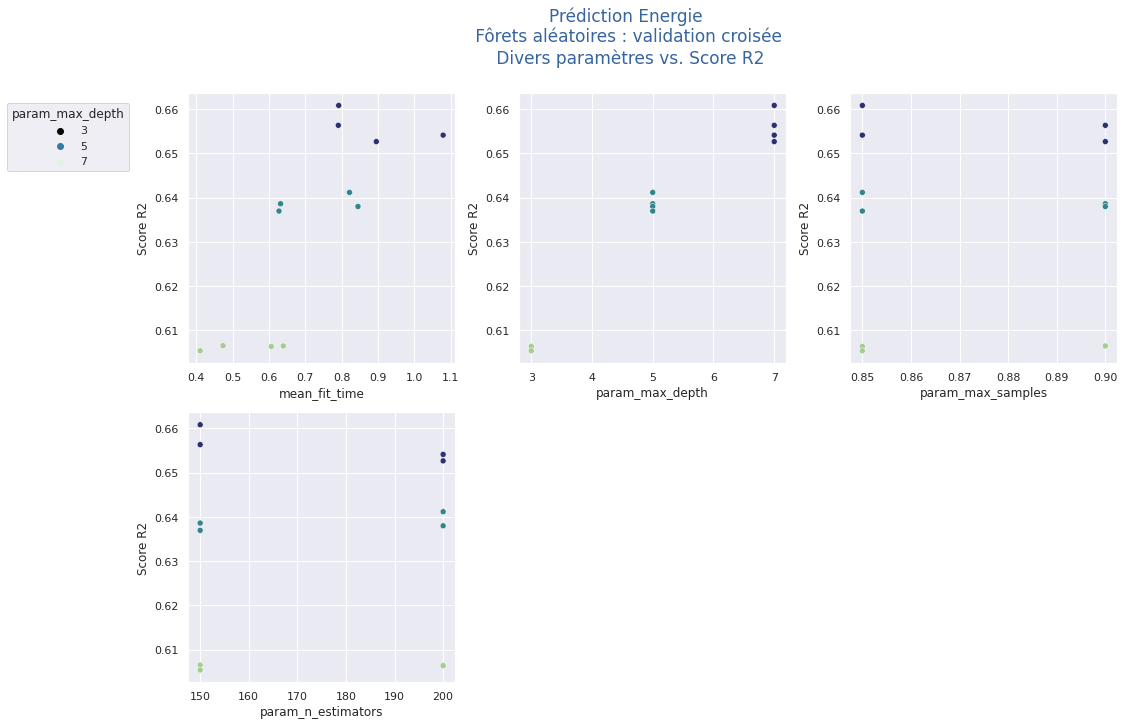

In [75]:
data = resultize(grid)[['mean_fit_time','param_max_depth', 
                         'param_max_samples', 'param_n_estimators','mean_test_score']]

fig = plt.figure(figsize=(14,14))
for idx,feat in enumerate(data.columns[:-1]):
    ax = fig.add_subplot(3,3, (idx+ 1))
    sns.scatterplot(data=data, 
                    x = data[feat],
                    y = data['mean_test_score'],
                    color='tab:purple',
                    hue = 'param_max_depth',
                    ax = ax,
                    legend = False,
                   palette = 'crest')
    ax.set_xlabel(feat)
    ax.set_ylabel('Score R2')
# last ax is separate from loop
# for getting legend info
ax = fig.add_subplot(3,3, 9)
sns.scatterplot(data=data, 
                x = data[feat],
                y = data['mean_test_score'],
                color='tab:purple',
                hue = 'param_max_depth',
                ax = ax,
               palette='mako')
ax.set_xlabel(feat)
ax.set_ylabel('Score R2')
handles, labels = ax.get_legend_handles_labels()    
ax.remove()
fig.legend(handles, labels, bbox_to_anchor=(0.01, 0.91), title = 'param_max_depth')
fig.suptitle('Prédiction Energie \n Fôrets aléatoires : validation croisée \n Divers paramètres vs. Score R2', fontsize=17,y=1, color=sns.color_palette('mako')[2])
plt.tight_layout()
fig.savefig('./img/energy_cv-forest.png',bbox_inches='tight')
plt.show()

### Entraînement fôret avec meilleurs paramètres<a class="anchor" id="forbest"></a>

In [76]:
estimator = RandomForestRegressor(**best_params)

start = time.time()
estimator.fit(X_train, y_train)
end = time.time()
fit_time = end-start

start = time.time()
y_pred = estimator.predict(X_test)
end = time.time()
exec_time = end-start

y_pred[:5]

array([1872687.4003582 , 4327980.80858542, 8274684.72333963,
       2818233.37755967, 9918607.4548259 ])

In [77]:
score(estimator,X_train,X_test,y_train,y_test)

score train : 0.8688, score test : 0.6128


[0.8688, 0.6128]

In [78]:
rmse(y_test,y_pred)

The RMSE is: 6960028.93


6960028.93

In [79]:
append_dic('RandomForest_afterCV', estimator,errors_df,X_train,X_test,y_train,y_test)

The RMSE is: 6960028.93
score train : 0.8688, score test : 0.6128


### Feature importance<a class="anchor" id="fimp"></a>

Nous allons étudier l'importance des variables interpretée par ce modèle (RandomForest) et par XGBoostRegressor.

In [80]:
feat_imp = pd.DataFrame({'feature':X.columns, 'feat_importance':estimator.feature_importances_})

In [81]:
feat_imp.sort_values(by='feat_importance', ascending=False).head(15)

,feature,feat_importance
5,LargestPropertyUseTypeGFA,0.688843
6,SecondLargestPropertyUseTypeGFA,0.056088
0,Latitude,0.037003
12,BuildType_Hospital/Health/Care,0.031940
3,NumberofFloors,0.030156
1,Longitude,0.020291
14,BuildType_Laboratory,0.017830
18,BuildType_Other,0.017715
2,YearAge,0.017373
4,PropertyGFAParking,0.012403


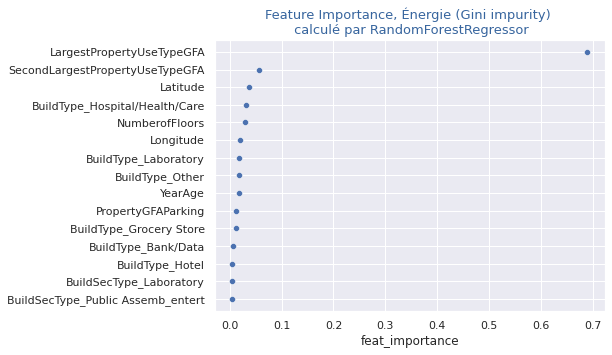

In [82]:
sorted_data = feat_imp.sort_values(by='feat_importance', 
                                   ascending=False, 
                                   ignore_index=True).iloc[:15,:]
fig = plt.figure(figsize=(7,5))
sns.scatterplot(y = sorted_data.index[::-1], x = sorted_data['feat_importance'])
plt.yticks(sorted_data.index[::-1], sorted_data['feature'])
plt.title('Feature Importance, Énergie (Gini impurity) \n calculé par RandomForestRegressor', 
          fontsize=13, 
          color = sns.color_palette('mako')[2])
fig.savefig('./img/energy_feat_import.png',bbox_inches='tight')
plt.show()

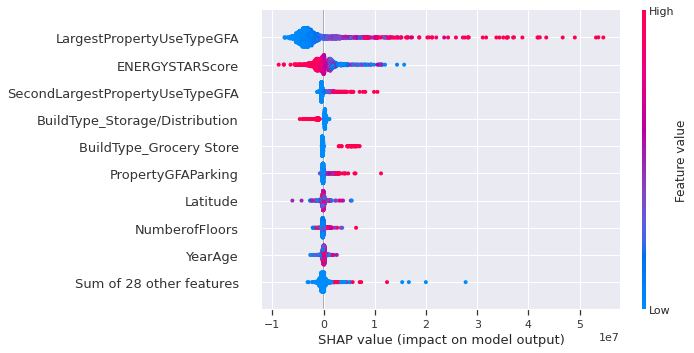

In [179]:
estimator = XGBRegressor().fit(X, y)

explainer = shap.Explainer(estimator)
shap_values = explainer(X)

shap.plots.beeswarm(shap_values)

### RandomForest avec transformation target: log<a class="anchor" id="forlog"></a>

In [84]:
estimator_trans = TransformedTargetRegressor(
    regressor = RandomForestRegressor(**best_params),
    func = np.log1p,
    inverse_func = np.expm1
)

start = time.time()
estimator_trans.fit(X_train, y_train)
end = time.time()
fit_time = end-start

In [85]:
start = time.time()
y_pred = estimator_trans.predict(X_test)
end = time.time()
predict_time = end-start

y_pred[:5]

array([ 785599.61751373,  122278.83456233, 4169536.27135035,
        190991.087817  , 4922771.01125253])

In [86]:
score(estimator_trans,X_train,X_test,y_train,y_test)

score train : 0.7353, score test : 0.5577


[0.7353, 0.5577]

In [87]:
rmse(y_test,y_pred)

The RMSE is: 7438506.25


7438506.25

In [88]:
append_dic('RandomForest_log_target',estimator_trans,errors_df,X_train,X_test,y_train,y_test)

The RMSE is: 7438506.25
score train : 0.7353, score test : 0.5577


## XGBoost<a class="anchor" id="xgb"></a>

Sans modifications des paramètres par défaut dans un premier temps, pour avoir une idée des performances

In [89]:
estimator = XGBRegressor()

start = time.time()
estimator.fit(X_train, y_train)
end = time.time()
fit_time = end-start

In [90]:
start = time.time()
y_pred = estimator.predict(X_test)
end = time.time()
predict_time = end-start

y_pred[:5]

array([  451654.44,  2965348.2 ,  8465304.  ,  2087341.2 , 10306042.  ],
      dtype=float32)

In [91]:
score(estimator,X_train,X_test,y_train,y_test)

score train : 0.9978, score test : 0.5982


[0.9978, 0.5982]

In [92]:
rmse(y_test,y_pred)

The RMSE is: 7090259.55


7090259.55

In [93]:
append_dic('XGBoost',estimator,errors_df,X_train,X_test,y_train,y_test)

The RMSE is: 7090259.55
score train : 0.9978, score test : 0.5982


## XGBoost régularisé<a class="anchor" id="xgbr"></a>
### Recherche de paramètres de régularisation : validation croisée

In [94]:
estimator = XGBRegressor()

lambdas = np.logspace(-5,5,15)

# parameters for cross validation (for regularisation)
params = {
          'max_depth' : [3,4,5],
          'lambda' : lambdas,
          'gamma' : [0.01,0.05],
          'subsample' : [0.85]
}

In [95]:
grid = GridSearchCV(estimator,
                    params,
                    cv=5,
                    n_jobs=-1,
                    return_train_score=True)

grid.fit(X_train,y_train)

GridSearchCV(cv=5,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    feature_types=None, gamma=None, gpu_id=None,
                                    grow_policy=None, importance_type=None,
                                    interaction_constraints=None,
                                    learning_rate=None, m...
                                    predictor=None, random_state=None, ...),
             n_jobs=-1,
             param_grid={'gamma': [0.01, 0.05],
                         'lambda': array([1.00000000e-05, 5.17947468e-05, 2.68269580e-04, 1.38949549e-03,
       7.19685673e-03, 3.72759372e-02, 1.93069773e-01, 1.00000000e+00,
       5.17947468e+00, 2.68269580e+01, 1.38949549e+02, 7.19685673e+02,
       3.72759372e+03, 1.93069773e+04, 1.00000000e+05]),
                         'max_depth': [3, 4, 5], 'subsample': [0.85]},
             return_train_score=True)

In [96]:
best_params = grid.best_params_
best_params

{'gamma': 0.01,
 'lambda': 0.037275937203149416,
 'max_depth': 3,
 'subsample': 0.85}

In [97]:
resultize(grid).head(3)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_gamma,param_lambda,param_max_depth,param_subsample,params,mean_test_score,std_test_score,rank_test_score,mean_train_score,std_train_score
15,0.287043,0.002720,0.006101,0.000242,0.01,0.037276,3,0.85,"{'gamma': 0.01, 'lambda': 0.037275937203149416...",0.623863,0.066107,1,0.970509,0.001592
60,0.299530,0.005080,0.006187,0.000265,0.05,0.037276,3,0.85,"{'gamma': 0.05, 'lambda': 0.037275937203149416...",0.623863,0.066107,1,0.970509,0.001592
64,0.405763,0.044965,0.006448,0.000577,0.05,0.19307,4,0.85,"{'gamma': 0.05, 'lambda': 0.19306977288832497,...",0.614325,0.053497,3,0.989701,0.000861


In [98]:
results = resultize(grid)
my_sorted_results = results.loc[(results['mean_train_score']<0.87)].sort_values(by='mean_test_score', ascending=False )
my_sorted_results.head(3)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_gamma,param_lambda,param_max_depth,param_subsample,params,mean_test_score,std_test_score,rank_test_score,mean_train_score,std_train_score
30,0.321255,0.026186,0.006804,0.000351,0.01,138.949549,3,0.85,"{'gamma': 0.01, 'lambda': 138.9495494373139, '...",0.609424,0.060346,11,0.812142,0.007567
75,0.288893,0.001626,0.006148,0.000170,0.05,138.949549,3,0.85,"{'gamma': 0.05, 'lambda': 138.9495494373139, '...",0.609424,0.060346,11,0.812142,0.007567
76,0.371184,0.003194,0.006176,0.000175,0.05,138.949549,4,0.85,"{'gamma': 0.05, 'lambda': 138.9495494373139, '...",0.605733,0.065030,21,0.858940,0.004507


In [99]:
my_best_params = my_sorted_results.iloc[0,:]['params']
my_best_params

{'gamma': 0.01, 'lambda': 138.9495494373139, 'max_depth': 3, 'subsample': 0.85}

### Entraînement XGBoost avec meilleurs paramètres<a class="anchor" id="xgbrbest"></a>


In [100]:
estimator = XGBRegressor(**my_best_params)

start = time.time()
estimator.fit(X_train, y_train)
end = time.time()
fit_time = end-start

In [101]:
start = time.time()
y_pred = estimator.predict(X_test)
end = time.time()
predict_time = end-start

y_pred[:5]

array([  750273.75,  3511668.8 ,  6763879.5 ,  2338831.8 , 13195286.  ],
      dtype=float32)

In [102]:
score(estimator,X_train,X_test,y_train,y_test)

score train : 0.8078, score test : 0.5905


[0.8078, 0.5905]

In [103]:
rmse(y_test,y_pred)

The RMSE is: 7157458.0


7157458.0

In [104]:
append_dic('XGBoost_reg',estimator,errors_df,X_train,X_test,y_train,y_test)

The RMSE is: 7157458.0
score train : 0.8078, score test : 0.5905


## Gradient Boosting<a class="anchor" id="gbo"></a>

In [105]:
estimator = GradientBoostingRegressor(random_state=0, learning_rate=0.055)

start = time.time()
estimator.fit(X_train, y_train)
end = time.time()
fit_time = end-start

In [106]:
start = time.time()
y_pred = estimator.predict(X_test)
end = time.time()
predict_time = end-start

y_pred[:5]

array([ 1543450.04791731,  3435973.71171007,  6765512.48805564,
        2409100.15337697, 12922675.53883196])

In [107]:
score(estimator,X_train,X_test,y_train,y_test)

score train : 0.8448, score test : 0.6689


[0.8448, 0.6689]

In [108]:
rmse(y_test,y_pred)

The RMSE is: 6436379.86


6436379.86

In [109]:
append_dic('GradientBoosting', estimator,errors_df,X_train,X_test,y_train,y_test)

The RMSE is: 6436379.86
score train : 0.8448, score test : 0.6689


# Comparatif résultats<a class="anchor" id="res"></a>

L'information des résultats modélisations organisée par ordre décroissant par rapport au score R2:

In [110]:
errors_real_df= pd.DataFrame(errors_df)
errors_real_df.sort_values(by='Test_R2_score', ascending=False)

,Name,Train_R2_score,Test_R2_score,RMSE,Fit_time,Predict_time
1,LinearRegression,0.6719,0.6947,6.180426e+06,0.014066,0.006403
3,Ridge_afterCV,0.6663,0.6895,6.232314e+06,0.012444,0.004678
5,Lasso_afterCV,0.6571,0.6764,6.362830e+06,0.009073,0.007636
12,GradientBoosting,0.8448,0.6689,6.436380e+06,0.190664,0.001850
7,SVR,0.7330,0.6147,9.350737e+06,0.085466,0.013980
8,RandomForest_afterCV,0.8688,0.6128,6.960029e+06,0.423573,0.013980
10,XGBoost,0.9978,0.5982,7.090260e+06,0.152951,0.005583
11,XGBoost_reg,0.8078,0.5905,7.157458e+06,0.108847,0.003967
9,RandomForest_log_target,0.7353,0.5577,7.438506e+06,0.417582,0.014509
0,DummyRegressor,0.0000,-0.0001,1.118565e+07,0.000715,0.000222


## Comparatif du score R2<a class="anchor" id="r2"></a>

Dans le graphe suivant nous comparons le score R2 pour les données d'entraînement et d'évaluation (test).

Le premier graphe n'est pas très parlant car il contient des scores de grande valeur absolue:

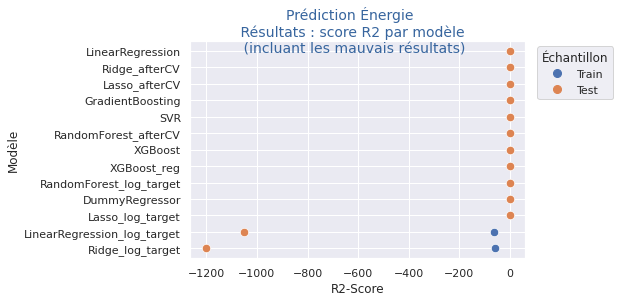

In [111]:
data = errors_real_df.sort_values(by='Test_R2_score').reset_index().copy()

legend_handles = [mlines.Line2D([], [], color=sns.color_palette()[0], 
                                marker='o',linestyle='None', 
                                markersize=8, label='Train'),
                  mlines.Line2D([], [], color=sns.color_palette()[1], 
                                marker='o',linestyle='None', 
                                markersize=8, label='Test')]
                 

sns.scatterplot(data=data,
                y = data.index,
                x = 'Train_R2_score',
                s=70)

sns.scatterplot(data=data,
                y = data.index,
                x = 'Test_R2_score',
                s=70)

sns.set(rc={'figure.figsize':(7,7)})
plt.yticks(data.index, data['Name'])
plt.ylabel('Modèle')
plt.xlabel('R2-Score')
plt.suptitle('Prédiction Énergie \n Résultats : score R2 par modèle \n (incluant les mauvais résultats)', fontsize=14,y=1, color=sns.color_palette('mako')[2])
plt.legend(handles=legend_handles, bbox_to_anchor=(1.02, 1), title='Échantillon')
plt.savefig('./img/energy_r2_all.png',bbox_inches='tight')
plt.show()

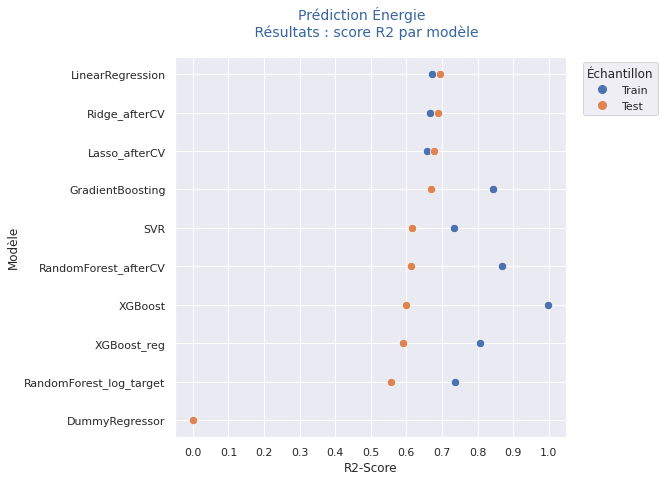

In [112]:
data = errors_real_df.sort_values(by='Test_R2_score').reset_index().copy()
data = data.loc[data['Name'].isin(['Ridge_log_target',
                                  'LinearRegression_log_target',
                                  'Lasso_log_target']) == False]
data.reset_index(inplace=True)

legend_handles = [mlines.Line2D([], [], color=sns.color_palette()[0], 
                                marker='o',linestyle='None', 
                                markersize=8, label='Train'),
                  mlines.Line2D([], [], color=sns.color_palette()[1], 
                                marker='o',linestyle='None', 
                                markersize=8, label='Test')]
                 

sns.scatterplot(data= data,
                y = data.index,
                x = 'Train_R2_score',
                s=70)

sns.scatterplot(data= data,
                y = data.index,
                x = 'Test_R2_score',
                s=70)
sns.set(rc={'figure.figsize':(7,5)})
plt.yticks(data.index, data['Name'])
plt.xticks(np.linspace(0,1,11))
plt.ylabel('Modèle')
plt.xlabel('R2-Score')
plt.suptitle('Prédiction Énergie \n Résultats : score R2 par modèle', fontsize=14, y=0.98, color=sns.color_palette('mako')[2])
plt.legend(handles=legend_handles, bbox_to_anchor=(1.25, 1), title='Échantillon')
plt.savefig('./img/energy_r2.png',bbox_inches='tight')
plt.show()

## Comparaison du RMSE<a class="anchor" id="rmse"></a>
(Racine de l'erreur quadratique moyenne)


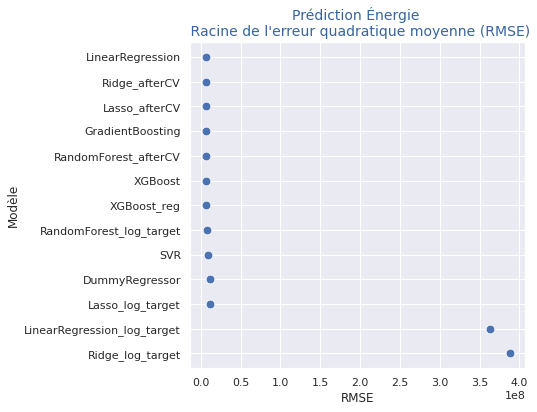

In [113]:
data = errors_real_df.sort_values(by='RMSE',ascending=False).reset_index().copy()

fig, ax = plt.subplots(figsize=(6,6))
sns.scatterplot(data=data, 
            y=data.index, 
            x = 'RMSE',
            ax=ax,
            s=75)
ax.set_yticks(data.index) # <--- set the ticks first
ax.set_yticklabels(data['Name'])
plt.xlabel('RMSE')
plt.ylabel('Modèle')
ax.set_title("Prédiction Énergie \n Racine de l'erreur quadratique moyenne (RMSE)",fontdict={'fontsize': 14}, color = sns.color_palette('mako')[2])
fig.savefig('./img/energy_rmse.png',bbox_inches='tight')
plt.show()

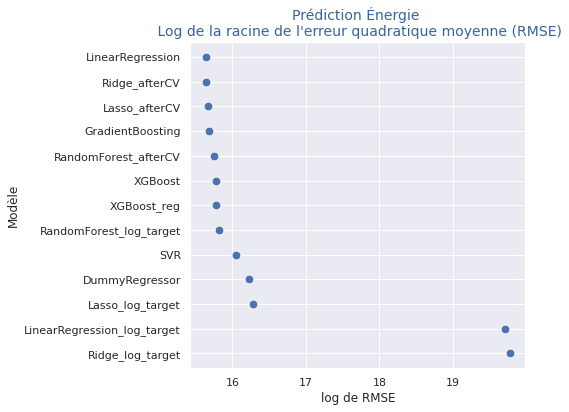

In [114]:
data = errors_real_df.sort_values(by='RMSE',ascending=False).reset_index().copy()

fig, ax = plt.subplots(figsize=(6,6))
sns.scatterplot(data=data, 
            y=data.index, 
            x = np.log(data['RMSE']),
            ax=ax,
            s=75)
ax.set_yticks(data.index) # <--- set the ticks first
ax.set_yticklabels(data['Name'])
plt.xlabel('log de RMSE')
plt.ylabel('Modèle')
ax.set_title("Prédiction Énergie \n Log de la racine de l'erreur quadratique moyenne (RMSE)",fontdict={'fontsize': 14}, color=sns.color_palette('mako')[2])
fig.savefig('./img/energy_log_rmse.png',bbox_inches='tight')
plt.show()

Nous avons un meilleur aperçu en enlevent ces mauvais résultats :

# Ajout de variable EnergyScore<a class="anchor" id="ene"></a>

Les predictions précédantes ne contenaient pas la variable `ENERGYSTARScore`. Selon [les informations](https://data.seattle.gov/dataset/2016-Building-Energy-Benchmarking/2bpz-gwpy) officielles :

> *C'est une note de 1 à 100 calculée par l'EPA qui évalue la performance énergétique globale d'un bien immobilier, sur la base de données nationales permettant de contrôler les différences entre le climat, les utilisations et les opérations du bâtiment. Un score de 50 représente la médiane nationale.*

Nous allons maintenant rajouter cette variable pour évaluer son intérêt.

## Lecture données

In [115]:
path     = './data/cleaned/'
filename = 'building_data_clean.csv'
df = pd.read_csv(path + filename)

##  Choix features (avec EnergyScore)

Choix de données structurels pour prédiction de consommation totale d'énergie:

| Feature                         | Choisi  | à prédire |
|---------------------------------|---------|-----------|
| Latitude                        |  x |  |
| Longitude                       |  x |  |
| YearBuilt                       |  x |  |
| NumberofFloors                  |  x |  |
| PropertyGFAParking              |  x |  |
| BuildType          |  x |  |
| BuildSecType          |  x |  |
| LargestPropertyUseTypeGFA       |  x |  |
| **ENERGYSTARScore**                |   **x** |  |
| SiteEnergyUse(kBtu)             |    | x |
| TotalGHGEmissions               |    |  |


In [116]:
# Renommer le target
df = df.rename(columns={'SiteEnergyUse(kBtu)' : 'target'})

# Traslation d'une variable
df['YearAge'] = df['YearBuilt'].max() - df['YearBuilt']
df.drop(columns='YearBuilt', inplace=True)

# Sélection des features
features = ['Latitude', 'Longitude','YearAge', 'NumberofFloors', 
            'PropertyGFAParking','BuildType', 'LargestPropertyUseTypeGFA',
           'BuildSecType','SecondLargestPropertyUseTypeGFA','ENERGYSTARScore']

# Suppression des individus à valeurs EnergyStarScore manquantes
df.dropna(inplace=True)

# Matrice de features X et target y
X = df[features]
y = df.target.copy()

# Codage des variables qualitatives
num_feat = X.select_dtypes(include=np.number).columns # Enregistrer les labes des var. num.
X = pd.get_dummies(X)

# Séparation: train test
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y, 
                                                    test_size=0.2, 
                                                    random_state=88)

print(f'X_train est de forme {X_train.shape}, et y_train : {y_train.shape} ')
print(f'X_test est de forme {X_test.shape}, et y_test : {y_test.shape} ')

# Standardisation des variables
sc = StandardScaler()
X_train[num_feat] = sc.fit_transform(X_train[num_feat])
X_test[num_feat] = sc.transform(X_test[num_feat])

X_train est de forme (834, 37), et y_train : (834,) 
X_test est de forme (209, 37), et y_test : (209,) 


## Modelisation avec EnergyStarScore

In [117]:
new_errors_df = {'Name': [],
             'Train_R2_score':[],
             'Test_R2_score':[],
             'RMSE' : [],
             'Fit_time' : [],
             'Predict_time': []}

## Dummy regressor (avec EnergyScore)

In [118]:
estimator = DummyRegressor(strategy='mean')

start = time.time()
estimator.fit(X_train, y_train)
end = time.time()
fit_time = end-start

In [119]:
start = time.time()
y_pred = estimator.predict(X_test)
end = time.time()
predict_time = end-start

y_pred[:5]

array([6655418.51356652, 6655418.51356652, 6655418.51356652,
       6655418.51356652, 6655418.51356652])

In [120]:
score(estimator,X_train,X_test,y_train,y_test)

score train : 0.0, score test : -0.0062


[0.0, -0.0062]

In [121]:
append_dic('DummyRegressor', estimator,new_errors_df,X_train,X_test,y_train,y_test)

The RMSE is: 9990923.04
score train : 0.0, score test : -0.0062


## Regression linéaire simple (avec EnergyScore)

In [122]:
estimator = LinearRegression()

start = time.time()
estimator.fit(X_train, y_train)
end = time.time()
fit_time = end-start

In [123]:
start = time.time()
y_pred = estimator.predict(X_test)
end = time.time()
predict_time = end-start

y_pred[:5]

array([ -182391.41589518,  4117701.56904536,  3192242.87069351,
       -4201038.94292465,  1397403.12367783])

In [124]:
score(estimator,X_train,X_test,y_train,y_test)

score train : 0.8011, score test : 0.7332


[0.8011, 0.7332]

In [125]:
append_dic('LinearRegression', estimator, new_errors_df,X_train,X_test,y_train,y_test)

The RMSE is: 5144866.79
score train : 0.8011, score test : 0.7332


## Regression ridge (avec EnergyScore)

### Choix d'hyperparamètres: Validation croisée

In [126]:
# parameters for cross validation
n_alphas = 50
alphas = np.logspace(-5,5,50)

# model 
estimator = RidgeCV(alphas=alphas,
                    scoring='r2',
                    cv=5)

estimator.fit(X_train, y_train)

RidgeCV(alphas=array([1.00000000e-05, 1.59985872e-05, 2.55954792e-05, 4.09491506e-05,
       6.55128557e-05, 1.04811313e-04, 1.67683294e-04, 2.68269580e-04,
       4.29193426e-04, 6.86648845e-04, 1.09854114e-03, 1.75751062e-03,
       2.81176870e-03, 4.49843267e-03, 7.19685673e-03, 1.15139540e-02,
       1.84206997e-02, 2.94705170e-02, 4.71486636e-02, 7.54312006e-02,
       1.20679264e-01, 1.93069773e-0...
       5.17947468e+00, 8.28642773e+00, 1.32571137e+01, 2.12095089e+01,
       3.39322177e+01, 5.42867544e+01, 8.68511374e+01, 1.38949549e+02,
       2.22299648e+02, 3.55648031e+02, 5.68986603e+02, 9.10298178e+02,
       1.45634848e+03, 2.32995181e+03, 3.72759372e+03, 5.96362332e+03,
       9.54095476e+03, 1.52641797e+04, 2.44205309e+04, 3.90693994e+04,
       6.25055193e+04, 1.00000000e+05]),
        cv=5, scoring='r2')

In [127]:
estimator.best_score_

0.7373814127370217

In [128]:
alpha = estimator.alpha_
alpha

5.1794746792312125

### Entraînement meilleurs paramètres (avec EnergyScore)

In [129]:
estimator = Ridge(alpha=alpha) # alpha trouvé avec CV si dessus

start = time.time()
estimator.fit(X_train, y_train)
end = time.time()
fit_time = end-start

In [130]:
start = time.time()
y_pred = estimator.predict(X_test)
end = time.time()
predict_time = end-start

y_pred[:5]

array([   57755.41835068,  4032936.18533664,  3487258.57452939,
       -3735849.21028315,  1162863.6260771 ])

In [131]:
score(estimator,X_train,X_test,y_train,y_test)

score train : 0.793, score test : 0.7473


[0.793, 0.7473]

In [132]:
append_dic('Ridge_afterCV', estimator, new_errors_df,X_train,X_test,y_train,y_test)

The RMSE is: 5006566.91
score train : 0.793, score test : 0.7473


## Regression LASSO (avec EnergyScore)

### Choix d'hyperparamètres: validation croisée (avec EnergyScore)

In [133]:
# parameters for cross validation
n_alphas = 50
alphas = np.logspace(-6,8,50)

# model 
estimator = LassoCV(n_alphas=50,
                    alphas=alphas,
                    cv=5)

estimator.fit(X_train, y_train)

LassoCV(alphas=array([1.00000000e-06, 1.93069773e-06, 3.72759372e-06, 7.19685673e-06,
       1.38949549e-05, 2.68269580e-05, 5.17947468e-05, 1.00000000e-04,
       1.93069773e-04, 3.72759372e-04, 7.19685673e-04, 1.38949549e-03,
       2.68269580e-03, 5.17947468e-03, 1.00000000e-02, 1.93069773e-02,
       3.72759372e-02, 7.19685673e-02, 1.38949549e-01, 2.68269580e-01,
       5.17947468e-01, 1.00000000e+0...
       7.19685673e+00, 1.38949549e+01, 2.68269580e+01, 5.17947468e+01,
       1.00000000e+02, 1.93069773e+02, 3.72759372e+02, 7.19685673e+02,
       1.38949549e+03, 2.68269580e+03, 5.17947468e+03, 1.00000000e+04,
       1.93069773e+04, 3.72759372e+04, 7.19685673e+04, 1.38949549e+05,
       2.68269580e+05, 5.17947468e+05, 1.00000000e+06, 1.93069773e+06,
       3.72759372e+06, 7.19685673e+06, 1.38949549e+07, 2.68269580e+07,
       5.17947468e+07, 1.00000000e+08]),
        cv=5, n_alphas=50)

In [134]:
alpha = estimator.alpha_
alpha

71968.567300115

### Entraînement LASSO avec meilleurs paramètres (avec EnergyScore)

In [135]:
estimator = Lasso(alpha=alpha) # alpha trouvé avec CV si dessus

start = time.time()
estimator.fit(X_train, y_train)
end = time.time()
fit_time = end-start

In [136]:
start = time.time()
y_pred = estimator.predict(X_test)
end = time.time()
predict_time = end-start

y_pred[:5]

array([  182105.43688873,  4216003.28049293,  4083178.14852622,
       -3458577.94896347,  1131539.45636633])

In [137]:
score(estimator,X_train,X_test,y_train,y_test)

score train : 0.7704, score test : 0.7431


[0.7704, 0.7431]

In [138]:
append_dic('Lasso_afterCV', estimator, new_errors_df,X_train,X_test,y_train,y_test)

The RMSE is: 5047915.09
score train : 0.7704, score test : 0.7431


## Support Vector Regression (avec EnergyStar)


In [139]:
sc_trgt = StandardScaler()

y_train_scaled = sc_trgt.fit_transform(y_train.values.reshape(len(y_train),1))
y_test_scaled = sc_trgt.transform(y_test.values.reshape(len(y_test),1))

### Choix d'hyperparamètre : validation croisée

In [140]:
estimator = SVR()

#parameters for cross validation
params = { 'kernel' : ['linear', 'poly', 'rbf'],
           'degree' : [2,3],
           'gamma' : ['scale', 'auto'],
           'tol' : [1e-3],
          'C' : [1,10],
          'epsilon' : [0.1]  
}

# cross validation 
grid = GridSearchCV(estimator,
                    params,
                    cv=5,
                    n_jobs=-1,
                    return_train_score=True)

grid.fit(X_train,y_train_scaled.ravel())

GridSearchCV(cv=5, estimator=SVR(), n_jobs=-1,
             param_grid={'C': [1, 10], 'degree': [2, 3], 'epsilon': [0.1],
                         'gamma': ['scale', 'auto'],
                         'kernel': ['linear', 'poly', 'rbf'], 'tol': [0.001]},
             return_train_score=True)

In [141]:
best_params = grid.best_params_
best_params

{'C': 10,
 'degree': 2,
 'epsilon': 0.1,
 'gamma': 'auto',
 'kernel': 'rbf',
 'tol': 0.001}

In [142]:
resultize(grid).head(3)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,param_degree,param_epsilon,param_gamma,param_kernel,param_tol,params,mean_test_score,std_test_score,rank_test_score,mean_train_score,std_train_score
23,0.056738,0.002252,0.010062,0.001395,10,3,0.1,auto,rbf,0.001,"{'C': 10, 'degree': 3, 'epsilon': 0.1, 'gamma'...",0.775542,0.076474,1,0.892945,0.012457
17,0.057970,0.001522,0.008445,0.000317,10,2,0.1,auto,rbf,0.001,"{'C': 10, 'degree': 2, 'epsilon': 0.1, 'gamma'...",0.775542,0.076474,1,0.892945,0.012457
20,0.086096,0.008522,0.013255,0.000712,10,3,0.1,scale,rbf,0.001,"{'C': 10, 'degree': 3, 'epsilon': 0.1, 'gamma'...",0.726166,0.071986,3,0.981372,0.004236


In [143]:
results = resultize(grid)
my_sorted_results = results.loc[(results['mean_train_score']<0.87)].sort_values(by='mean_test_score', ascending=False )
my_sorted_results.head(3)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,param_degree,param_epsilon,param_gamma,param_kernel,param_tol,params,mean_test_score,std_test_score,rank_test_score,mean_train_score,std_train_score
16,0.060929,0.007689,0.005631,0.000119,10,2,0.1,auto,poly,0.001,"{'C': 10, 'degree': 2, 'epsilon': 0.1, 'gamma'...",0.717278,0.122198,6,0.809208,0.019289
5,0.029716,0.000789,0.008668,0.001391,1,2,0.1,auto,rbf,0.001,"{'C': 1, 'degree': 2, 'epsilon': 0.1, 'gamma':...",0.711184,0.085218,7,0.762997,0.026480
11,0.034347,0.001972,0.008582,0.000120,1,3,0.1,auto,rbf,0.001,"{'C': 1, 'degree': 3, 'epsilon': 0.1, 'gamma':...",0.711184,0.085218,7,0.762997,0.026480


In [144]:
my_best_params = my_sorted_results.iloc[0,:]['params']
my_best_params

{'C': 10,
 'degree': 2,
 'epsilon': 0.1,
 'gamma': 'auto',
 'kernel': 'poly',
 'tol': 0.001}

### Entraînement avec meilleurs paramètres

In [145]:
estimator = SVR(**my_best_params)

start = time.time()
estimator.fit(X_train, y_train_scaled.ravel())
end = time.time()
fit_time = end-start

In [146]:
start = time.time()
y_pred = estimator.predict(X_test)
end = time.time()
predict_time = end-start

y_pred[:5]

array([-0.55299872, -0.32453675, -0.28691009, -0.58229528, -0.55998604])

In [147]:
estimator.score(X_train,y_train_scaled)

0.8136168724443582

In [148]:
estimator.score(X_test,y_test_scaled)

0.7541520512981732

In [149]:
y_pred = sc_trgt.inverse_transform(y_pred.reshape(-1,1)) # pour que la fonction suivante fasse le bon calcul du RMSE
append_dic('SVR',estimator,new_errors_df,X_train,X_test,y_train_scaled,y_test_scaled)

The RMSE is: 9094546.92
score train : 0.8136, score test : 0.7542


In [150]:
# Pour vérifier que le score est bien calculé ci dessus : 
y_pred = estimator.predict(X_test)
y_pred_transf = sc_trgt.inverse_transform(y_pred.reshape(-1,1))
r2_score(y_test,y_pred_transf)

0.7541520512981732

## Fôrets aléatoires (avec EnergyScore)

### Recherche hyper-paramètres: validation croisée (avec EnergyScore)

In [151]:
estimator = RandomForestRegressor()

# parameters for cross validation
params = {'n_estimators': [100,150,200],
          'max_features' : ['sqrt',int(np.sqrt(X.shape[1]))+1,int(np.sqrt(X.shape[1]))+2],
          'max_depth' : [3,5],
          'max_samples': [0.7, 0.85]
                 
}

In [152]:
grid = GridSearchCV(estimator,
                    params,
                    cv=5,
                    n_jobs=-1,
                    return_train_score=True)

grid.fit(X_train,y_train)

GridSearchCV(cv=5, estimator=RandomForestRegressor(), n_jobs=-1,
             param_grid={'max_depth': [3, 5], 'max_features': ['sqrt', 7, 8],
                         'max_samples': [0.7, 0.85],
                         'n_estimators': [100, 150, 200]},
             return_train_score=True)

In [153]:
best_params = grid.best_params_
best_params

{'max_depth': 5, 'max_features': 8, 'max_samples': 0.7, 'n_estimators': 200}

In [154]:
resultize(grid).head(3)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_max_features,param_max_samples,param_n_estimators,params,mean_test_score,std_test_score,rank_test_score,mean_train_score,std_train_score
32,0.470753,0.059574,0.030065,0.004318,5,8,0.7,200,"{'max_depth': 5, 'max_features': 8, 'max_sampl...",0.681498,0.071012,1,0.838736,0.008548
34,0.315261,0.002615,0.021461,0.000997,5,8,0.85,150,"{'max_depth': 5, 'max_features': 8, 'max_sampl...",0.675262,0.070931,2,0.844976,0.010698
30,0.219806,0.020001,0.017227,0.002115,5,8,0.7,100,"{'max_depth': 5, 'max_features': 8, 'max_sampl...",0.674321,0.066746,3,0.833250,0.012548


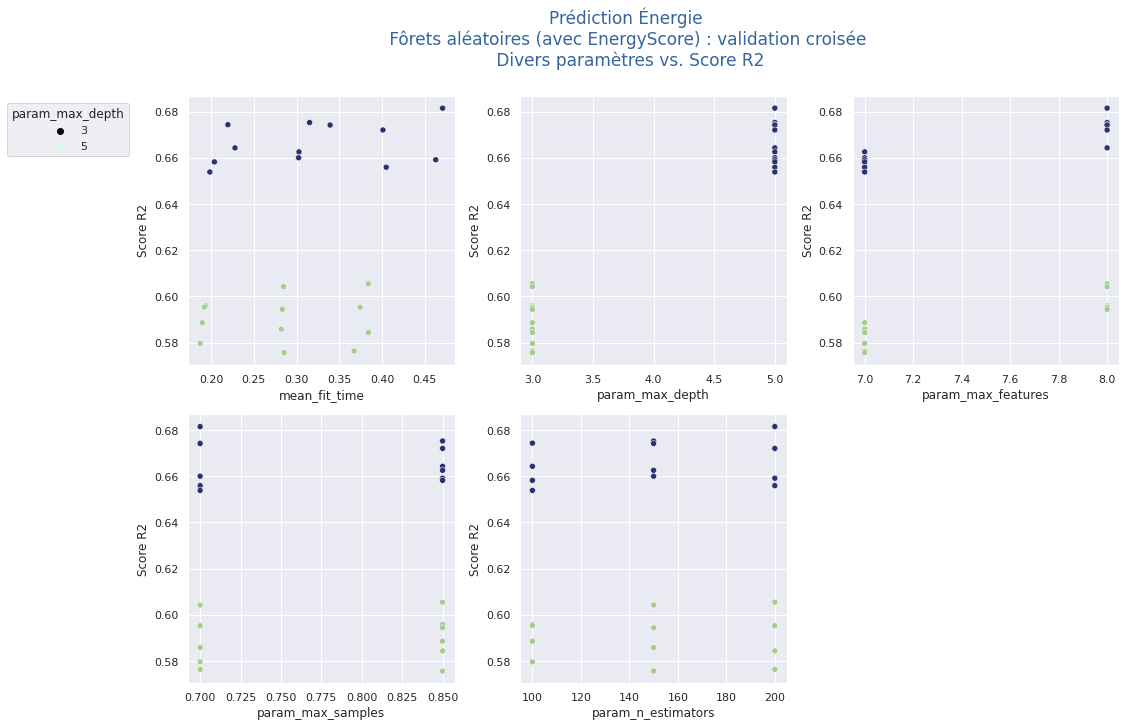

In [155]:
data = resultize(grid)[['mean_fit_time','param_max_depth', 'param_max_features', 
                         'param_max_samples', 'param_n_estimators','mean_test_score']]
data = data.loc[data['param_max_features'] != 'sqrt']

fig = plt.figure(figsize=(14,14))
for idx,feat in enumerate(data.columns[:-1]):
    ax = fig.add_subplot(3,3, (idx+ 1))
    sns.scatterplot(data=data, 
                    x = data[feat],
                    y = data['mean_test_score'],
                    color='tab:purple',
                    hue = 'param_max_depth',
                    ax = ax,
                    legend = False,
                   palette = 'crest')
    ax.set_xlabel(feat)
    ax.set_ylabel('Score R2')
# last ax is separate from loop
# for getting legend info
ax = fig.add_subplot(3,3, 9)
sns.scatterplot(data=data, 
                x = data[feat],
                y = data['mean_test_score'],
                color='tab:purple',
                hue = 'param_max_depth',
                ax = ax,
               palette='mako')
ax.set_xlabel(feat)
ax.set_ylabel('Score R2')
handles, labels = ax.get_legend_handles_labels()    
ax.remove()
fig.legend(handles, labels, bbox_to_anchor=(0.01, 0.91), title = 'param_max_depth')
fig.suptitle('Prédiction Énergie \n Fôrets aléatoires (avec EnergyScore) : validation croisée \n Divers paramètres vs. Score R2', fontsize=17,y=1, color=sns.color_palette('mako')[2])
plt.tight_layout()
fig.savefig('./img/energy_score_cv-forest.png',bbox_inches='tight')
plt.show()

In [156]:
results = resultize(grid)

my_results = results.loc[results['mean_train_score']<0.88].sort_values(by='mean_test_score', ascending=False)
my_results.head(3)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_max_features,param_max_samples,param_n_estimators,params,mean_test_score,std_test_score,rank_test_score,mean_train_score,std_train_score
32,0.470753,0.059574,0.030065,0.004318,5,8,0.7,200,"{'max_depth': 5, 'max_features': 8, 'max_sampl...",0.681498,0.071012,1,0.838736,0.008548
34,0.315261,0.002615,0.021461,0.000997,5,8,0.85,150,"{'max_depth': 5, 'max_features': 8, 'max_sampl...",0.675262,0.070931,2,0.844976,0.010698
30,0.219806,0.020001,0.017227,0.002115,5,8,0.7,100,"{'max_depth': 5, 'max_features': 8, 'max_sampl...",0.674321,0.066746,3,0.833250,0.012548


In [157]:
my_best_params = my_results.iloc[0,:]['params']
my_best_params

{'max_depth': 5, 'max_features': 8, 'max_samples': 0.7, 'n_estimators': 200}

### Entraînement fôret avec meilleurs paramètres (avec EnergyScore)

In [158]:
estimator = RandomForestRegressor(**my_best_params)

start = time.time()
estimator.fit(X_train, y_train)
end = time.time()
fit_time = end-start

start = time.time()
y_pred = estimator.predict(X_test)
end = time.time()
exec_time = end-start

y_pred[:5]

array([2651089.05807498, 2992794.2171212 , 3757608.51363704,
       2475723.92284644, 2825017.97788758])

In [159]:
score(estimator,X_train,X_test,y_train,y_test)

score train : 0.8297, score test : 0.6458


[0.8297, 0.6458]

In [160]:
append_dic('RandomForest_afterCV', estimator, new_errors_df,X_train,X_test,y_train,y_test)

The RMSE is: 5927190.86
score train : 0.8297, score test : 0.6458


## XGBoost régularisé (avec EnergyScore)
### Recherche de paramètres de régularisation : validation croisée

In [161]:
estimator = XGBRegressor()

alphas = np.logspace(-6,6,10)
lambdas = np.logspace(-6,6,10)

params = {
    'max_depth' : [2,3,4],
   'lambda' : lambdas,
    'alpha' : alphas,
    'gamma' : [0.1,0.05],
    'subsample' : [0.85]
}

In [162]:
grid = GridSearchCV(estimator,
                    params,
                    cv=5,
                    n_jobs=-1,
                    return_train_score=True)

grid.fit(X_train,y_train)

GridSearchCV(cv=5,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    feature_types=None, gamma=None, gpu_id=None,
                                    grow_policy=None, importance_type=None,
                                    interaction_constraints=None,
                                    learning_rate=None, m...
             param_grid={'alpha': array([1.00000000e-06, 2.15443469e-05, 4.64158883e-04, 1.00000000e-02,
       2.15443469e-01, 4.64158883e+00, 1.00000000e+02, 2.15443469e+03,
       4.64158883e+04, 1.00000000e+06]),
                         'gamma': [0.1, 0.05],
                         'lambda': array([1.00000000e-06, 2.15443469e-05, 4.64158883e-04, 1.00000000e-02,
       2.15443469e-01, 4.64158883e+00, 1.00000000e+02, 2.15443469e+03,
       4.64158883e+04, 1.00000000e+06]),
                         'max_depth': [2, 3, 4], 'subsample': [0.85]},
             return_train_score=True)

In [163]:
best_params = grid.best_params_
best_params

{'alpha': 46415.888336127726,
 'gamma': 0.1,
 'lambda': 0.01,
 'max_depth': 3,
 'subsample': 0.85}

In [164]:
results = resultize(grid)
my_sorted_results = results.loc[(results['mean_train_score']<0.87)].sort_values(by='mean_test_score', ascending=False )
my_sorted_results.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_alpha,param_gamma,param_lambda,param_max_depth,param_subsample,params,mean_test_score,std_test_score,rank_test_score,mean_train_score,std_train_score
528,0.141028,0.001536,0.005498,0.000159,46415.888336,0.05,100.0,2,0.85,"{'alpha': 46415.888336127726, 'gamma': 0.05, '...",0.723345,0.088551,401,0.847205,0.011492
498,0.143455,0.003151,0.005537,0.000115,46415.888336,0.1,100.0,2,0.85,"{'alpha': 46415.888336127726, 'gamma': 0.1, 'l...",0.723345,0.088551,401,0.847205,0.011492
348,0.160531,0.021603,0.006564,0.001371,4.641589,0.05,100.0,2,0.85,"{'alpha': 4.641588833612772, 'gamma': 0.05, 'l...",0.723335,0.088552,403,0.847238,0.011492
318,0.140900,0.001899,0.005422,0.000130,4.641589,0.1,100.0,2,0.85,"{'alpha': 4.641588833612772, 'gamma': 0.1, 'la...",0.723335,0.088552,403,0.847238,0.011492
288,0.160741,0.023915,0.005934,0.000329,0.215443,0.05,100.0,2,0.85,"{'alpha': 0.21544346900318823, 'gamma': 0.05, ...",0.723335,0.088552,405,0.847238,0.011492


In [165]:
my_best_params = my_sorted_results.iloc[0,:]['params']
my_best_params

{'alpha': 46415.888336127726,
 'gamma': 0.05,
 'lambda': 100.0,
 'max_depth': 2,
 'subsample': 0.85}

### Entraînement XGBoost regularisé avec meilleurs paramètres

In [166]:
estimator = XGBRegressor(**my_best_params)

start = time.time()
estimator.fit(X_train, y_train)
end = time.time()
fit_time = end-start

In [167]:
start = time.time()
y_pred = estimator.predict(X_test)
end = time.time()
predict_time = end-start

y_pred[:5]

array([ -78244.016, 3765618.8  , 2124881.2  , -155791.   ,  430910.84 ],
      dtype=float32)

In [168]:
score(estimator,X_train,X_test,y_train,y_test)

score train : 0.8464, score test : 0.7148


[0.8464, 0.7148]

In [169]:
rmse(y_test,y_pred)

The RMSE is: 5318697.34


5318697.34

In [170]:
append_dic('XGBoost_reg',estimator,new_errors_df,X_train,X_test,y_train,y_test)

The RMSE is: 5318697.34
score train : 0.8464, score test : 0.7148


## Gradient Boosting (avec EnergyScore)

In [171]:
estimator = GradientBoostingRegressor(random_state=0,
                                      learning_rate=0.017) # paramètre pour régularisation

start = time.time()
estimator.fit(X_train, y_train)
end = time.time()
fit_time = end-start

In [172]:
start = time.time()
y_pred = estimator.predict(X_test)
end = time.time()
predict_time = end-start

y_pred[:5]

array([3170477.10560311, 3369579.33839216, 4557071.47790455,
       2858316.88119057, 2990193.30580344])

In [173]:
score(estimator,X_train,X_test,y_train,y_test)

score train : 0.843, score test : 0.7193


[0.843, 0.7193]

In [174]:
append_dic('GradientBoosting', estimator, new_errors_df,X_train,X_test,y_train,y_test)

The RMSE is: 5276750.41
score train : 0.843, score test : 0.7193


# Comparatif erreurs (avec EnergyScore)<a class="anchor" id="erre"></a>

In [175]:
new_errors_real_df = pd.DataFrame(new_errors_df)
new_errors_real_df.sort_values(by='Test_R2_score', ascending=False)

,Name,Train_R2_score,Test_R2_score,RMSE,Fit_time,Predict_time
4,SVR,0.8136,0.7542,9094546.92,0.034987,0.005062
2,Ridge_afterCV,0.7930,0.7473,5006566.91,0.011326,0.008436
3,Lasso_afterCV,0.7704,0.7431,5047915.09,0.018875,0.003358
1,LinearRegression,0.8011,0.7332,5144866.79,0.004758,0.003900
7,GradientBoosting,0.8430,0.7193,5276750.41,0.141908,0.002079
6,XGBoost_reg,0.8464,0.7148,5318697.34,0.074257,0.004309
5,RandomForest_afterCV,0.8297,0.6458,5927190.86,0.185569,0.005062
0,DummyRegressor,0.0000,-0.0062,9990923.04,0.000391,0.000196


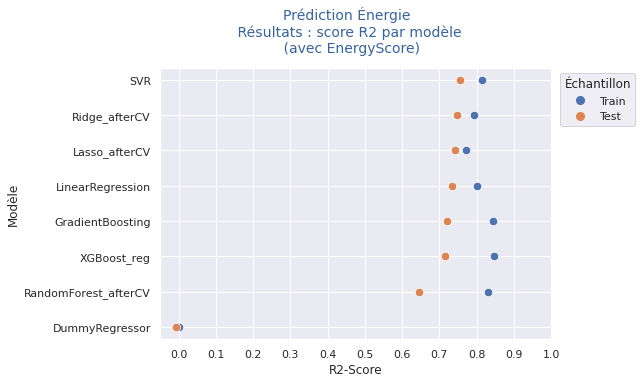

In [176]:
data = new_errors_real_df.sort_values(by='Test_R2_score').reset_index().copy()

legend_handles = [mlines.Line2D([], [], color=sns.color_palette()[0], 
                                marker='o',linestyle='None', 
                                markersize=8, label='Train'),
                  mlines.Line2D([], [], color=sns.color_palette()[1], 
                                marker='o',linestyle='None', 
                                markersize=8, label='Test')]
                 

sns.scatterplot(data= data,
                y = data.index,
                x = 'Train_R2_score',
                s=70)

sns.scatterplot(data= data,
                y = data.index,
                x = 'Test_R2_score',
                s=70)
sns.set(rc={'figure.figsize':(7,5)})
plt.yticks(data.index, data['Name'])
plt.xticks(np.linspace(0,1,11))
plt.ylabel('Modèle')
plt.xlabel('R2-Score')
plt.suptitle('Prédiction Énergie \n Résultats : score R2 par modèle \n (avec EnergyScore)', fontsize=14, y=1.05, color=sns.color_palette('mako')[2])
plt.legend(handles=legend_handles, bbox_to_anchor=(1.23, 1), title='Échantillon')
plt.savefig('./img/energy_score_r2.png',bbox_inches='tight')
plt.show()

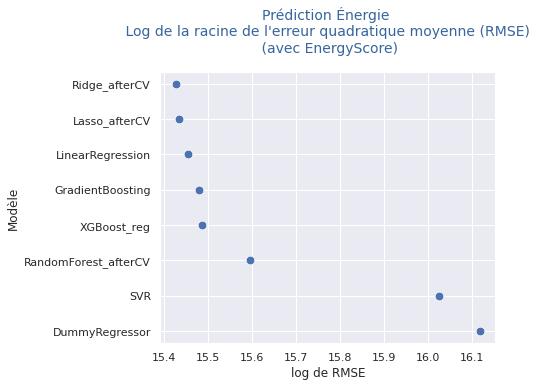

In [177]:
data = new_errors_real_df.sort_values(by='RMSE',ascending=False).reset_index().copy()

fig, ax = plt.subplots(figsize=(6,5))
sns.scatterplot(data=data, 
            y=data.index, 
            x = np.log(data['RMSE']),
            ax=ax,
            s=75)
ax.set_yticks(data.index) # <--- set the ticks first
ax.set_yticklabels(data['Name'])
plt.xlabel('log de RMSE')
plt.ylabel('Modèle')
ax.set_title("Prédiction Énergie \n Log de la racine de l'erreur quadratique moyenne (RMSE) \n (avec EnergyScore)",fontdict={'fontsize': 14}, color=sns.color_palette('mako')[2],y=1.05)
plt.savefig('./img/energy_score_log_rmse.png',bbox_inches='tight')
plt.show()

# Conclusions, commentaires et choix de modèle<a class="anchor" id="concl"></a>

## Intérêt de la variable EnergyStarScore

Nous avons testé tous les modèles sans et avec la variable EnergyStarScore. Les performences ont augmenté **considérablément**. Voir tableaux des résultats et graphe de comparaisons. La plupart de modèles ont eu des bonnes performances, le score R2 pour l'échantillon de test de tous les modèles est au dessus de **0.74**, sans compter RandomForest (voir [Autres remarques](#autr) ci-dessous.).

En conclusion la variable EnergyStarScore a un intérêt et c'est important de la calculer pour avoir des prédictions fiables de consommation d'énergie, nous la gardons pour prendre un décision du choix de modèle.


## Choix de modèle


Après l'étude des résultats, le modèle choisi pour prédire la consommation totale d'énergie est la regression **Ridge**. Voici toutes les raisons qui ont conduit à ce choix : 

* Clairement les trois modèles : **SVR, Ridge** et **LASSO** ont des résultats assez proches. Ce sont ceux avec le score R2 le plus élevé : tous au dessus de **0.74**.

* Le modèle choisi est celui avec la valeur la plus basse du RMSE. Le modèle avec le meilleur score R2 (SVR) a la plus grande RMSE.

* Nous avons choisi la regrssion ridge car il a un niveau raisonnable de surapprentissage. (0.79 de score R2 pour l'échantillon de train)

* Le temps d'entraînement et prediction est très raisonnable ; son temps d'entraînement est parmi le plus bas de tous les modèles entraînés.


## Autres remarques

* Tous le modèles en général ont été extrêment sensibles aux outliers (Sans la variable EnergyStarScore). Des petits changements dans le nettoyage des donnés ont donné des gros changements du niveau des performances des modèles. Cela reste un mystère pour moi.

* Dans un premier temps nous n'avions pas considéré la variables BuildSecType, qui dit l'utilisation de la deuxième aire la plus grande de la propriété. Avoir ajouté cette variable a changé considérablement les performances des modèles.

* Le modèle **RandomForest** a été un peu décevant ici. Nous attendions des meilleurs résultats. Après plusieurs essaies et différents paramètres de régularisation, ça reste un mystère pour moi.